# Siamese Neural Network

## Library

In [1]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [37]:
from pathlib import Path
import matplotlib.pyplot as plt
import random

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import requests
import zipfile

In [3]:
print(Path.cwd())

/home/studio-lab-user/sagemaker-studiolab-notebooks/Paper-With-Code/Siamese Neural Network


In [4]:
ROOT_DIR = Path("/home/studio-lab-user/sagemaker-studiolab-notebooks")  # Working directory.

DATASET_DIR = ROOT_DIR / "Data"  # Directory to store dataset.
DATA_DIR = DATASET_DIR / "Omniglot"  # Directory of dataset.

DATASET_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)  # Create directory if it do not exist.

image_dir = DATA_DIR / "omniglot"

In [5]:
print(image_dir)

/home/studio-lab-user/sagemaker-studiolab-notebooks/Data/Omniglot/omniglot


## Prepare Dataset

### Download Dataset

In [6]:
if not image_dir.is_dir():
    URL = "https://www.dropbox.com/s/nfe0uj4eieivr2s/omniglot.zip?raw=1"
    file_name = "omniglot.zip"
    file_path = DATA_DIR / file_name  # Download file path.

    r = requests.get(URL, allow_redirects=True)
    open(file_path, 'wb').write(r.content)

    print('Dataset downloaded successfully!')


    zip_file_path = file_path
    extract_directory = DATA_DIR

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_directory)

    Path.unlink(file_path)  # Remove zip file.

    print('Dataset extracted successfully!')
    
else:
    print('Dataset already exist!')

Dataset already exist!


In [7]:
background_image_dir = image_dir / "images_background"
evaluation_image_dir = image_dir / "images_evaluation"

In [8]:
print(background_image_dir)

/home/studio-lab-user/sagemaker-studiolab-notebooks/Data/Omniglot/omniglot/images_background


### Create Dataset

In [99]:
def create_dataset(image_dir):
    path_list = []  # Store the path of images.
    class_list = []  # Store the class name.
    
    paths = Path(background_image_dir).glob('*')
    
    for path in paths:
        # Because path is object not string.
        path_str = str(path.name)  # Class name.
        
        sub_paths = Path(path).glob('*')
    
        for sub_path in sub_paths:
            sub_path_str = str(sub_path.name)
            class_list.append(path_str + '-' + sub_path_str)
            
            ssub_paths = Path(sub_path).glob('*')
            
            for ssub_path in ssub_paths:
                ssub_path_str = str(ssub_path)  # path of image.
                path_list.append(ssub_path_str)

    return path_list, class_list

In [100]:
train_path_list, train_class_list = create_dataset(background_image_dir)
val_path_list, val_class_list = create_dataset(evaluation_image_dir)
test_path_list, test_class_list = create_dataset(evaluation_image_dir)

In [101]:
print("number of images:", len(train_path_list))
print("number of class:", len(train_class_list))

number of images: 19285
number of class: 964


In [102]:
idx_to_class = {i:j for i, j in enumerate(train_class_list)}  # Add index to class.
class_to_idx = {value:key for key,value in idx_to_class.items()}  # Convert class name to index.

In [104]:
# Test
temp_class = train_path_list[0].split('/')[-3] + "-" + train_path_list[0].split('/')[-2]  # Get class name from the path.
print(temp_class)  

for i in range(5):
    print(i, idx_to_class[i])
    
print("temp_class has index:", class_to_idx[temp_class])

Alphabet_of_the_Magi-character01
0 Alphabet_of_the_Magi-character01
1 Alphabet_of_the_Magi-character02
2 Alphabet_of_the_Magi-character03
3 Alphabet_of_the_Magi-character04
4 Alphabet_of_the_Magi-character05
temp_class has index: 0


### Dataset Class

In [77]:
class Omniglot(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image1_path = random.choice(self.image_paths)
        # Get class name from the path.
        image1_class_name = image1_path.split('/')[-3] + '-' + image1_path.split('/')[-2]
        
        # 50% of images to be in the same class.
        from_same_class = random.randint(0, 1)  # 1 for same class.
        
        if from_same_class:
            while True:
                image2_path = random.choice(self.image_paths)
                image2_class_name = image2_path.split('/')[-3] + '-' + image2_path.split('/')[-2]
                if image1_class_name == image2_class_name:
                    break
        else:
            while True:
                image2_path = random.choice(self.image_paths)
                image2_class_name = image2_path.split('/')[-3] + '-' + image2_path.split('/')[-2]
                if image1_class_name != image2_class_name:
                    break
        
        image1 = torchvision.io.read_image(image1_path)
        image2 = torchvision.io.read_image(image2_path)
        
        if self.transform is not None:
            image1 = self.transform(image=image1)["image"]
            image2 = self.transform(image=image2)["image"]
        
        label = from_same_class
        
        return image1, image2, label

In [67]:
from pprint import pprint

### Load Dataset

In [78]:
train_dataset = Omniglot(train_path_list)
val_dataset = Omniglot(val_path_list)
test_dataset = Omniglot(test_path_list)

torch.Size([1, 105, 105])
torch.Size([1, 105, 105])
1


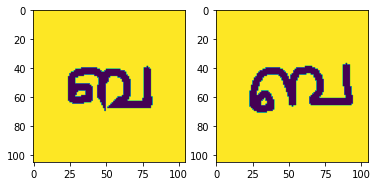

In [93]:
for image1, image2, label in train_dataset:
    print(image1.shape)
    print(image2.shape)
    print(label)
    
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image1.permute(1, 2, 0))
    ax2.imshow(image2.permute(1, 2, 0))

    break

### Create Dataloader

In [150]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=8)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=8)

In [131]:
for image1, image2, label in train_dataloader:
    print(image1.shape)
    print(image2.shape)
    print(label.shape)
    break

torch.Size([8, 1, 105, 105])
torch.Size([8, 1, 105, 105])
torch.Size([8])


## Create Model

In [112]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 10),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 7),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, 4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 4),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(9216, 4096), 
            nn.Sigmoid()
        )
        self.output = nn.Linear(4096, 1)
        
    def _forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x
    
    def forward(self, input1, input2):
        output1 = self._forward(input1)
        output2 = self._forward(input2)
        distance = torch.abs(output1 - output2)
        output = self.output(distance)
        return output

In [113]:
siamese_network = SiameseNetwork()

if torch.cuda.is_available():
    siamese_network.cuda()

In [136]:
summary(siamese_network, input_size=[(1, 105, 105), (1, 105, 105)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           6,464
              ReLU-2           [-1, 64, 96, 96]               0
         MaxPool2d-3           [-1, 64, 48, 48]               0
            Conv2d-4          [-1, 128, 42, 42]         401,536
              ReLU-5          [-1, 128, 42, 42]               0
         MaxPool2d-6          [-1, 128, 21, 21]               0
            Conv2d-7          [-1, 128, 18, 18]         262,272
              ReLU-8          [-1, 128, 18, 18]               0
         MaxPool2d-9            [-1, 128, 9, 9]               0
           Conv2d-10            [-1, 256, 6, 6]         524,544
             ReLU-11            [-1, 256, 6, 6]               0
           Linear-12                 [-1, 4096]      37,752,832
          Sigmoid-13                 [-1, 4096]               0
           Conv2d-14           [-1, 64,

In [123]:
loss_fn = torch.nn.BCEWithLogitsLoss(size_average=True)
optimizer = optim.Adam(siamese_network.parameters(), lr = 0.0005)

In [149]:
for i, (image0, image1, label) in enumerate(train_dataloader):
    print(i)
    print(image0.shape)
    print(image1.shape)
    print(label.shape)
    
    print(image0.dtype)
    print(label.dtype)
    break

0
torch.Size([8, 1, 105, 105])
torch.Size([8, 1, 105, 105])
torch.Size([8])
torch.uint8
torch.int64


In [ ]:
counter = []
loss_history = [] 
iteration_number= 0
loss_val = 0

for epoch in range(100):
    for i, (image0, image1, label) in enumerate(train_dataloader):
        
        # image0, image1, label = image0.cuda(), image1.cuda(), label.cuda()
        image0, image1 = image0.float(), image1.float()
        label = label.reshape(-1, 1).float()

        optimizer.zero_grad()
        output = siamese_network(image0, image1)
        
        loss = loss_fn(output, label)
        
        loss_val += loss.item()
        
        loss.backward()
        optimizer.step()

    
    print(f"Epoch number {epoch}\n Current loss {loss.item()}\n")
    iteration_number += 10

    counter.append(iteration_number)
    loss_history.append(loss.item())